# Classical Markowitz Portfolio Optimization

This notebook implements the **classical mean–variance optimization** (Markowitz model) 
as a **baseline** for comparison against quantum approaches.

### Contents

1. **Problem Setup**

   - Expected returns vector $μ$
   - Covariance matrix $Σ$
   - Risk-aversion parameter $λ$ sweep

2. **Optimization (cvxpy)**

   - Minimize: $−μᵀw + λ wᵀΣw$
   - Constraints: $Σ w = 1$, $w ≥ 0$

3. **Results & Visualization**

   - Optimal allocation
   - Bar chart and pie chart of weights

### Notes

- Provides a classical baseline to validate quantum results
- If Markowitz solution matches Fractional VQE, correctness is confirmed
- Extendable to real data (Yahoo Finance)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import os

np.random.seed(0)

In [2]:
# Problem setup
mu = np.array([0.10, 0.20, 0.15, 0.12])  # Expected returns
Sigma = np.array([
    [0.005, -0.010, 0.004, -0.002],
    [-0.010, 0.040, -0.002, 0.004],
    [0.004, -0.002, 0.023, 0.002],
    [-0.002, 0.004, 0.002, 0.018]
])

n_assets = len(mu)
lambdas = np.round(np.linspace(0.1, 5.0, 15, dtype=float), 2)  # risk-aversion parameters
allocations = []

for lam in lambdas:
    # Define optimization variables
    w = cp.Variable(n_assets)

    # Objective: -mu^T w + lam * w^T Sigma w
    objective = cp.Minimize(-mu @ w + lam * cp.quad_form(w, Sigma))

    # Constraints: weights sum to 1, non-negative
    constraints = [cp.sum(w) == 1, w >= 0]

    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve()

    w_val = np.where(w.value < 0, 0, w.value)
    w_val /= np.sum(w_val)
    allocations.append(w_val)

    print(f"λ={lam:.2f} → " + ", ".join([f"Asset {i+1}: {100*wi:.1f}%" for i, wi in enumerate(w_val)]))


λ=0.10 → Asset 1: 0.0%, Asset 2: 100.0%, Asset 3: 0.0%, Asset 4: 0.0%
λ=0.45 → Asset 1: 0.0%, Asset 2: 100.0%, Asset 3: 0.0%, Asset 4: 0.0%
λ=0.80 → Asset 1: 0.0%, Asset 2: 84.0%, Asset 3: 16.0%, Asset 4: 0.0%
λ=1.15 → Asset 1: 0.0%, Asset 2: 69.8%, Asset 3: 30.2%, Asset 4: 0.0%
λ=1.50 → Asset 1: 0.0%, Asset 2: 62.2%, Asset 3: 37.8%, Asset 4: 0.0%
λ=1.85 → Asset 1: 0.0%, Asset 2: 57.5%, Asset 3: 42.5%, Asset 4: 0.0%
λ=2.20 → Asset 1: 9.2%, Asset 2: 52.8%, Asset 3: 38.1%, Asset 4: 0.0%
λ=2.55 → Asset 1: 19.1%, Asset 2: 48.8%, Asset 3: 32.1%, Asset 4: 0.0%
λ=2.90 → Asset 1: 26.7%, Asset 2: 45.8%, Asset 3: 27.5%, Asset 4: 0.0%
λ=3.25 → Asset 1: 32.6%, Asset 2: 43.4%, Asset 3: 23.9%, Asset 4: 0.0%
λ=3.60 → Asset 1: 37.4%, Asset 2: 41.5%, Asset 3: 21.0%, Asset 4: 0.0%
λ=3.95 → Asset 1: 40.8%, Asset 2: 39.7%, Asset 3: 18.5%, Asset 4: 1.0%
λ=4.30 → Asset 1: 43.6%, Asset 2: 38.1%, Asset 3: 16.5%, Asset 4: 1.9%
λ=4.65 → Asset 1: 46.0%, Asset 2: 36.7%, Asset 3: 14.7%, Asset 4: 2.6%
λ=5.00 → Asse

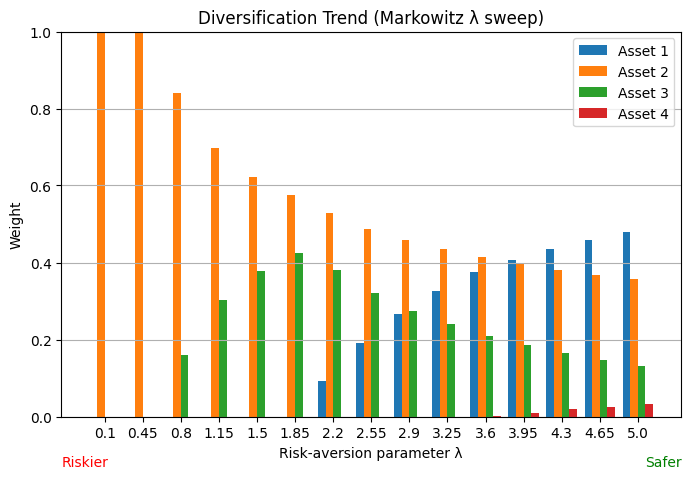

In [3]:
# Grouped bar chart
allocations = np.array(allocations)
x = np.arange(len(lambdas))  # λ positions
bar_width = 0.2

plt.figure(figsize=(8,5))
for i in range(n_assets):
    plt.bar(x + i*bar_width, allocations[:, i], bar_width, label=f"Asset {i+1}")

plt.xticks(x + bar_width*(n_assets-1)/2, [f"{lam}" for lam in lambdas])
plt.xlabel("Risk-aversion parameter λ")
plt.ylabel("Weight")
plt.ylim(0, 1)
plt.title("Diversification Trend (Markowitz λ sweep)")
plt.legend()
plt.grid(axis="y")

# Add "Riskier" and "Safer" labels under the axis
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.text(xmin, ymin - 0.1, "Riskier", ha="left", va="top", fontsize=10, color="red")
plt.text(xmax, ymin - 0.1, "Safer", ha="right", va="top", fontsize=10, color="green")

plt.savefig("images/Markowitz_Lambda_Sweep.png", dpi=200, bbox_inches="tight")
plt.show()

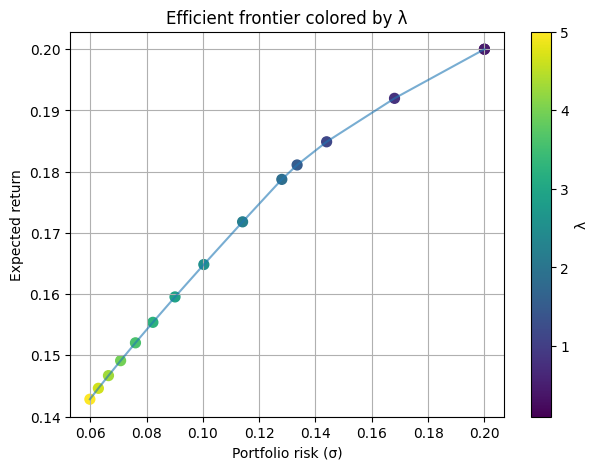

In [4]:
# Risk–Return Tradeoff (Markowitz λ sweep)
# For each λ, compute expected return and risk (variance) of the optimized portfolio
# Sort by risk, color by λ

returns = []
risks = []

for w_val in allocations:
    R = mu @ w_val
    sigma2 = w_val.T @ Sigma @ w_val
    returns.append(R)
    risks.append(np.sqrt(sigma2))

risks = np.array(risks)
returns = np.array(returns)
order = np.argsort(risks)
risks_s = risks[order]
returns_s = returns[order]
lambdas_s = np.array(lambdas)[order]

plt.figure(figsize=(7,5))
sc = plt.scatter(risks_s, returns_s, c=lambdas_s, cmap="viridis", s=50)
plt.plot(risks_s, returns_s, alpha=0.6)
cbar = plt.colorbar(sc)
cbar.set_label("λ")
plt.xlabel("Portfolio risk (σ)")
plt.ylabel("Expected return")
plt.title("Efficient frontier colored by λ")
plt.grid(True)
plt.savefig("images/Markowitz_Risk_Return_Colored.png", dpi=200, bbox_inches="tight")
plt.show()